In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [11]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


This is normalizing step. Here Compose is a pipeline for converting 0-255 to 0-1 and then converting 0-1 to -1 - 1

In [12]:
class MNISTCSV(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx, 0]
        image = self.data.iloc[idx, 1:].values.astype(np.uint8)
        image = image.reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [17]:
train_dataset = MNISTCSV(
    '/kaggle/input/mnist-in-csv/mnist_train.csv',
    transform=transform
)

test_dataset = MNISTCSV(
    '/kaggle/input/mnist-in-csv/mnist_test.csv',
    transform=transform
)


In [18]:
train_loader=DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)
test_loader=DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [19]:
import torch.nn.functional as F

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3),   # (1, 28, 28) → (32, 26, 26)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                # → (32, 13, 13)

    nn.Conv2d(32, 64, kernel_size=3),  # → (64, 11, 11)
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                # → (64, 5, 5)

    nn.Flatten(),                      # → (64 * 5 * 5)

    nn.Linear(64 * 5 * 5, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [22]:
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.1527
Epoch [2/5], Loss: 0.0466
Epoch [3/5], Loss: 0.0303
Epoch [4/5], Loss: 0.0241
Epoch [5/5], Loss: 0.0173


In [23]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.89%


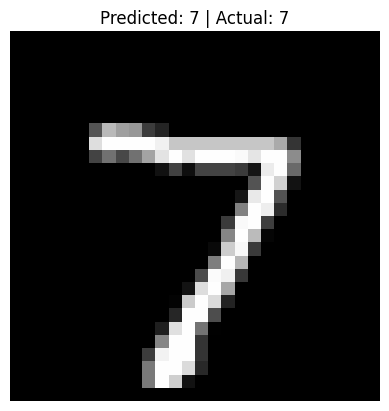

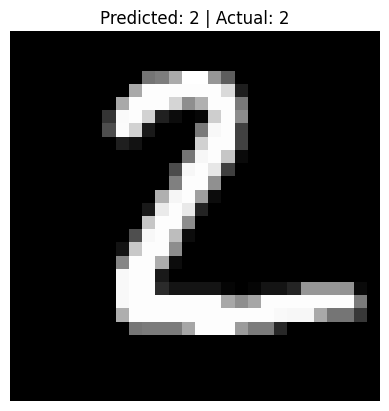

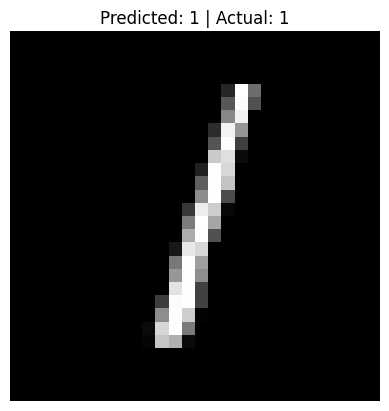

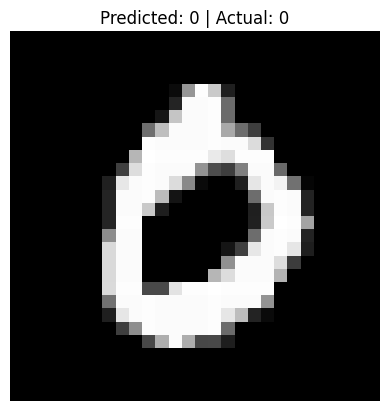

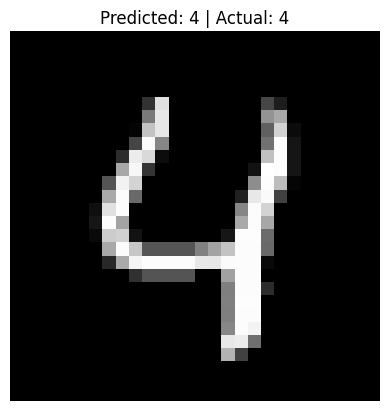

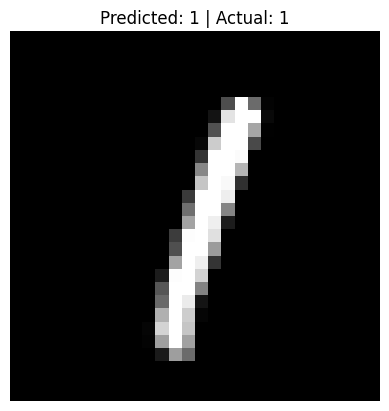

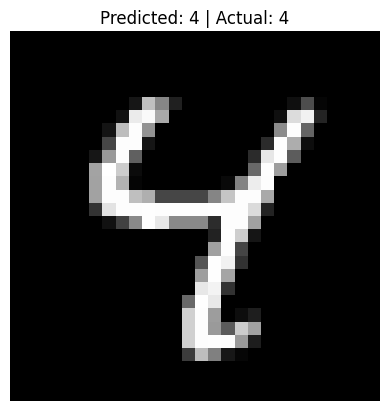

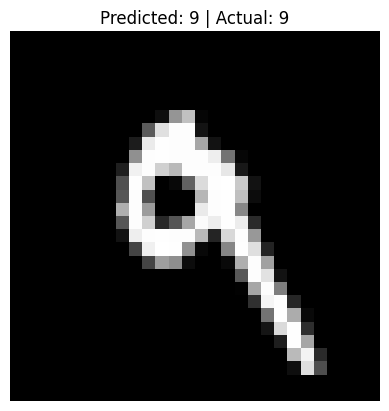

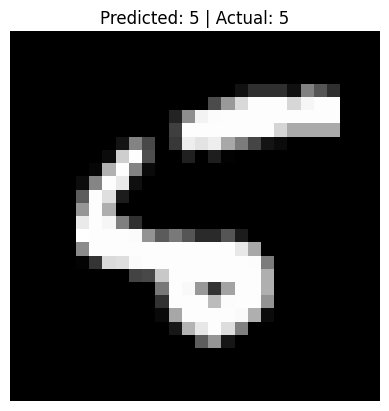

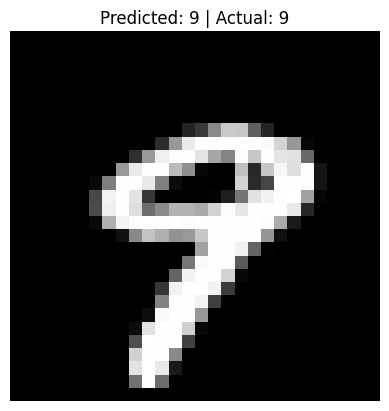

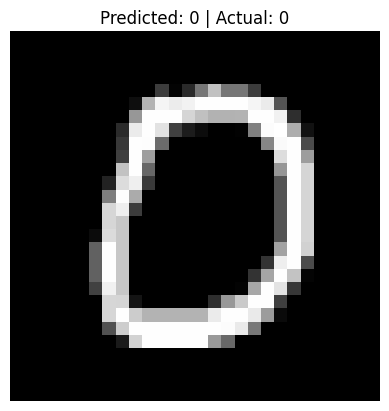

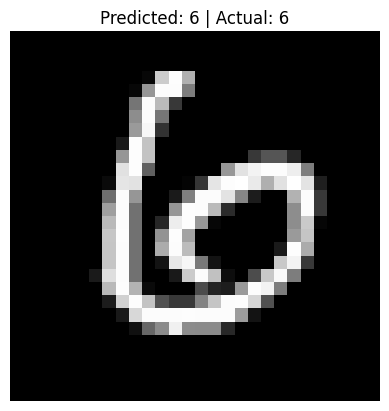

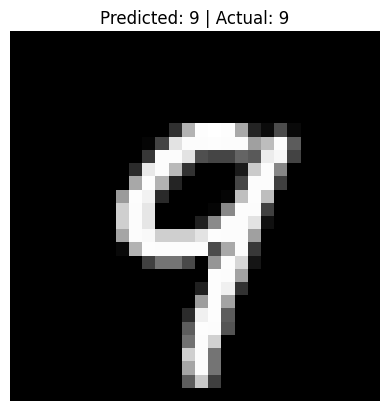

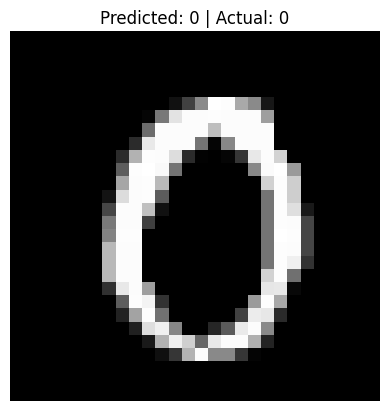

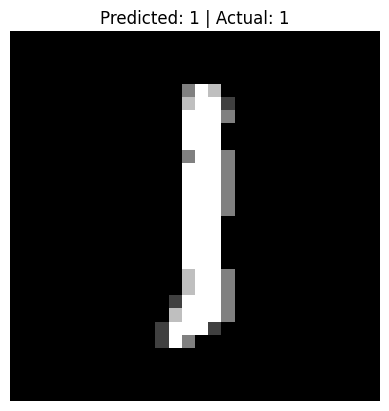

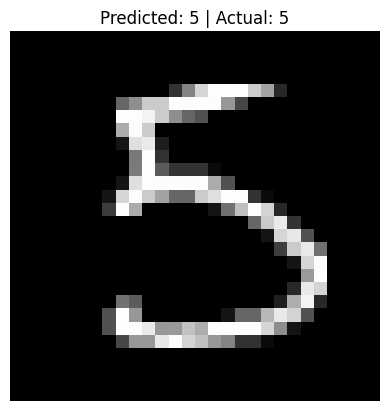

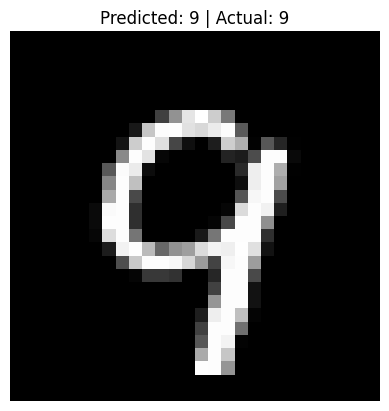

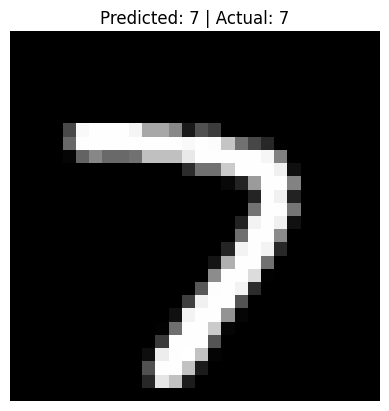

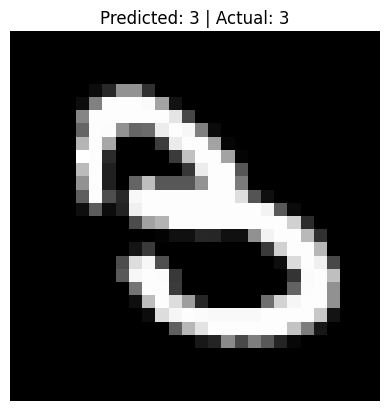

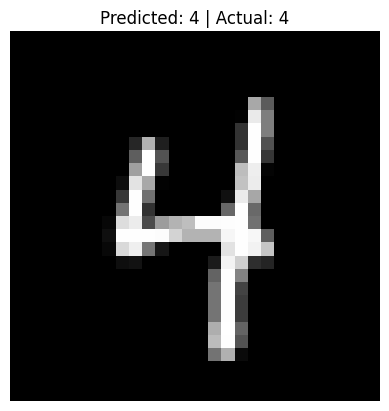

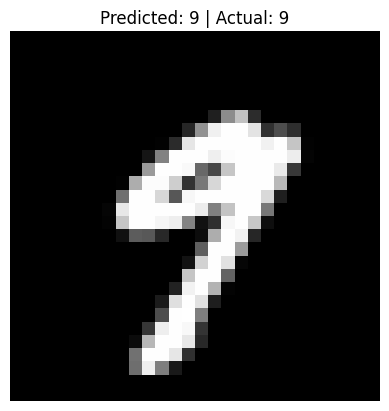

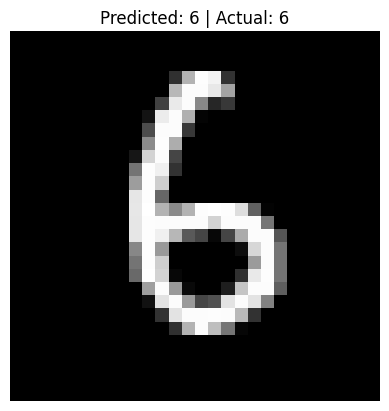

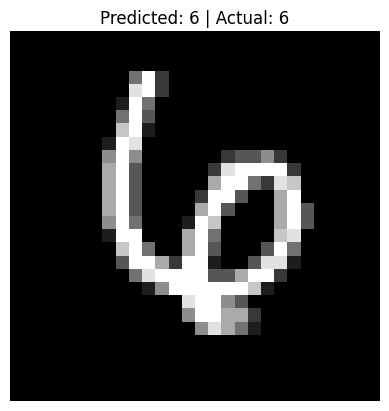

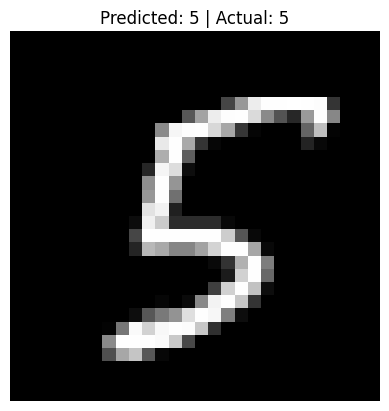

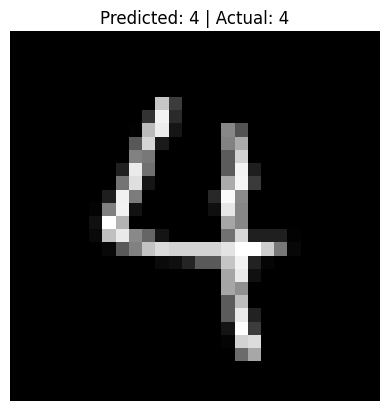

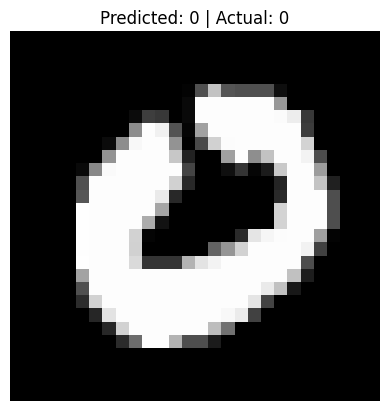

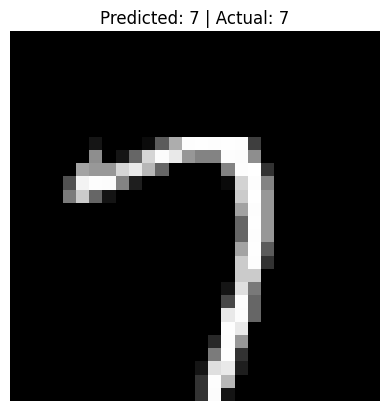

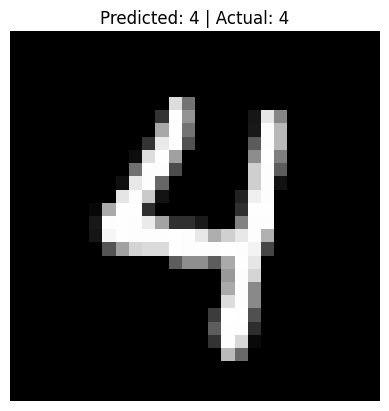

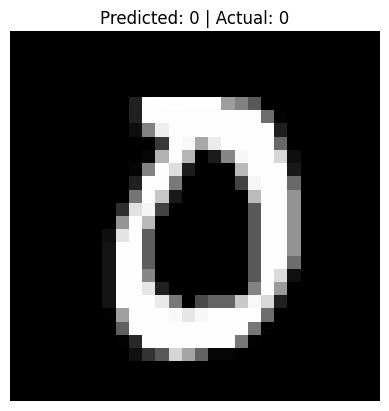

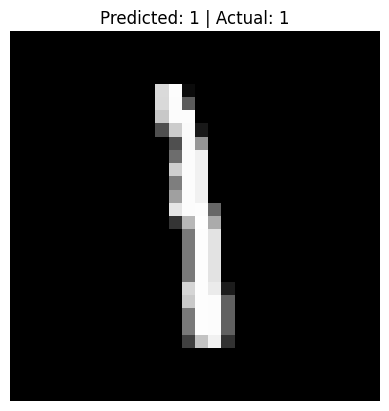

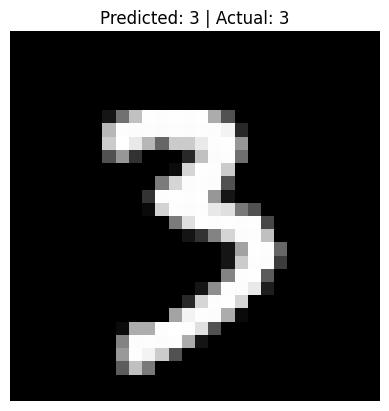

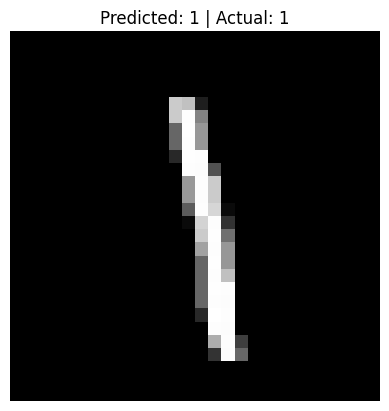

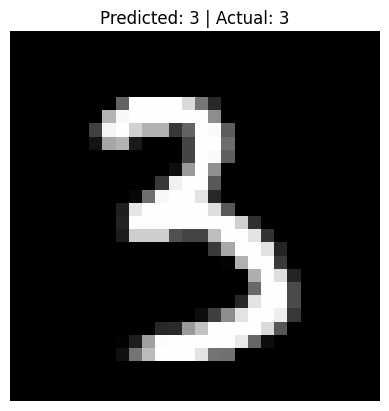

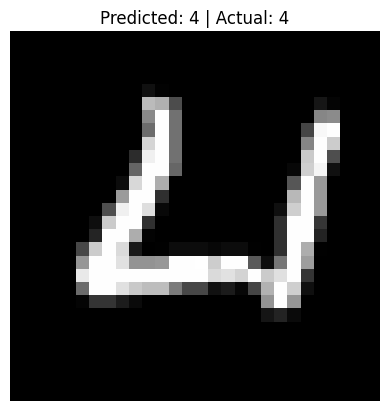

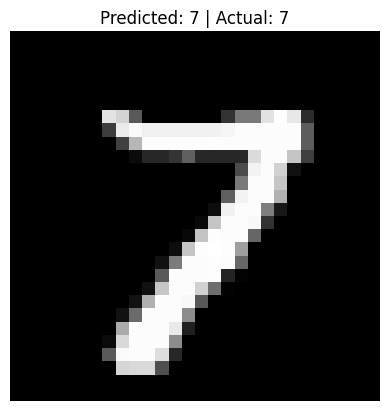

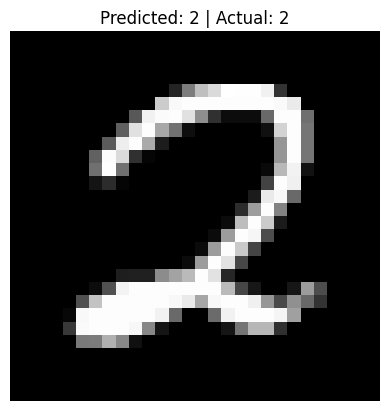

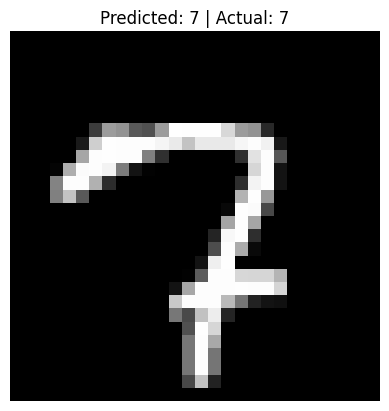

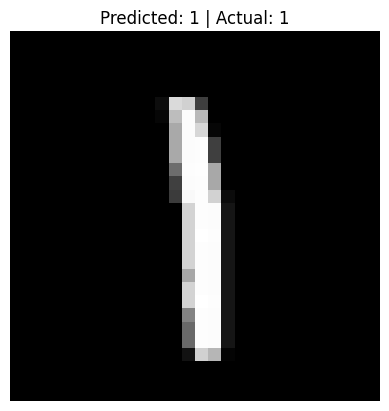

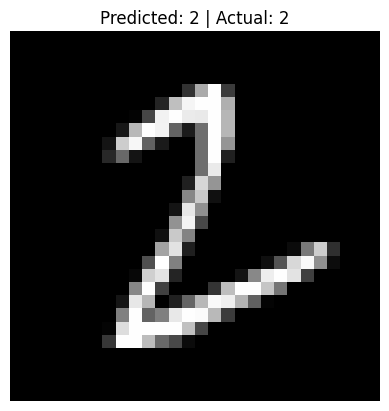

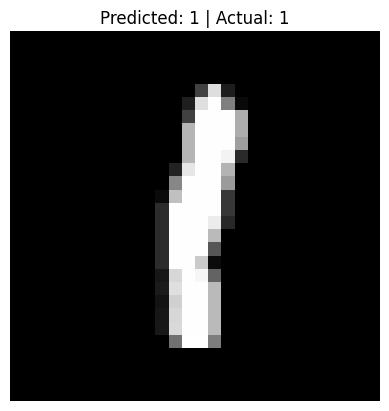

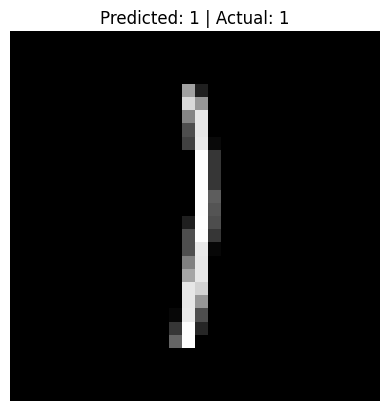

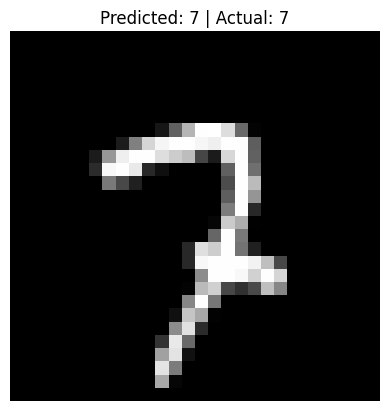

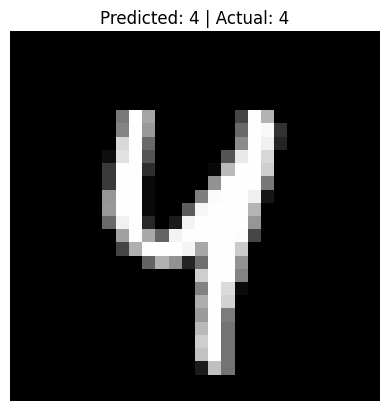

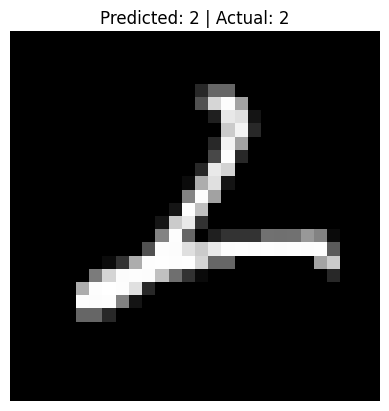

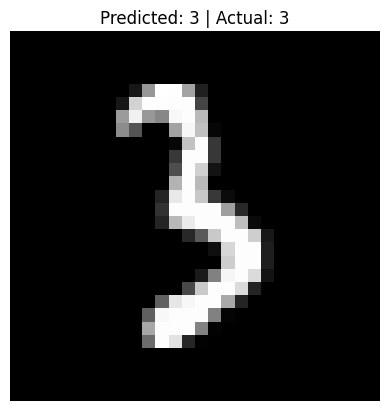

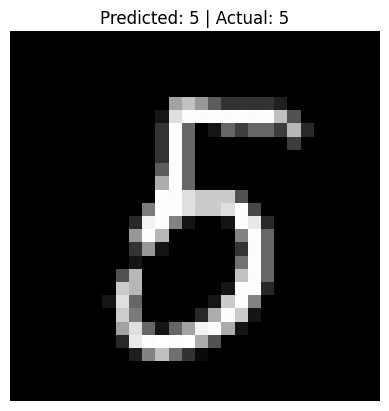

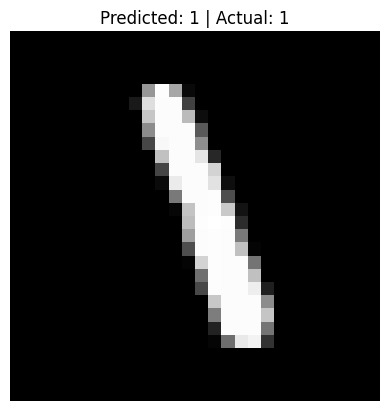

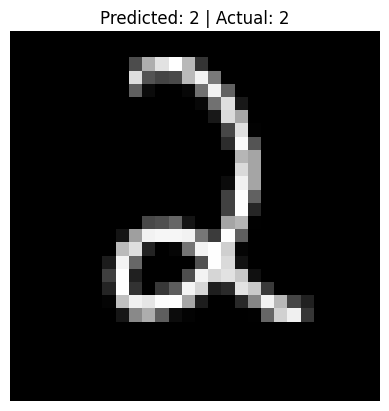

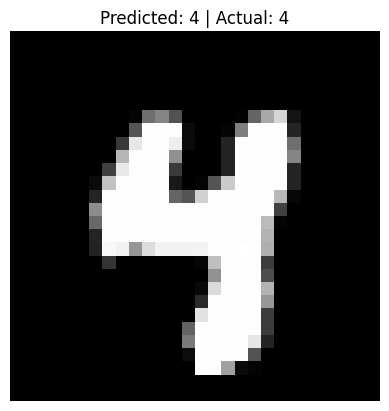

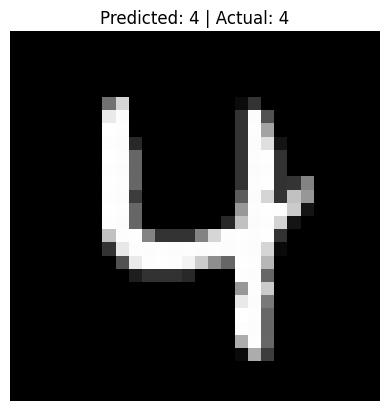

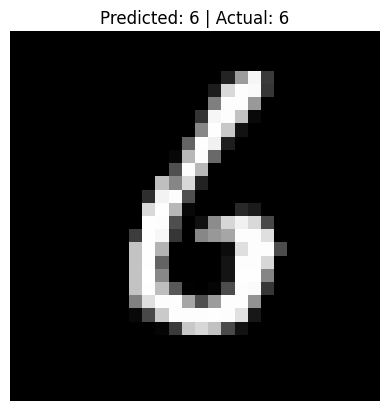

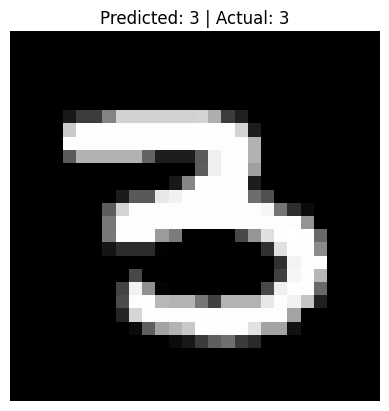

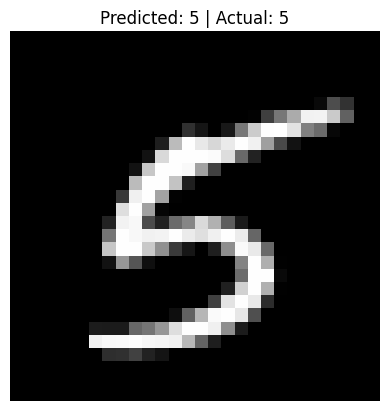

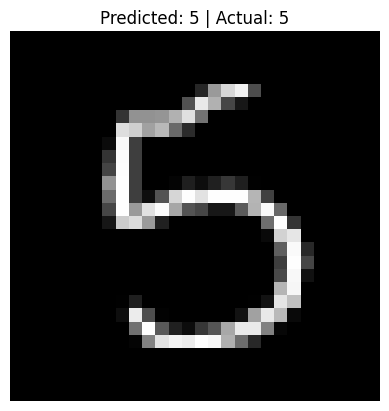

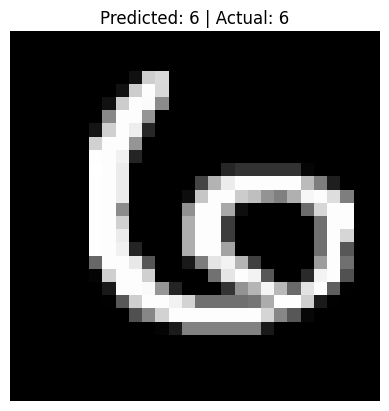

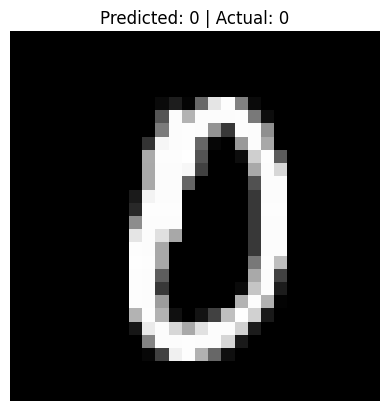

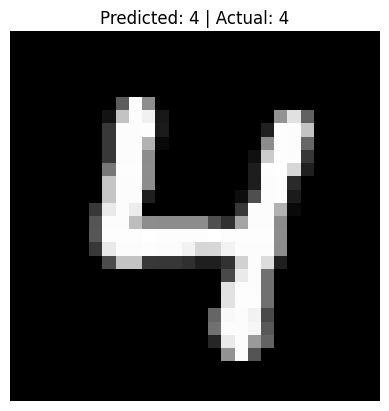

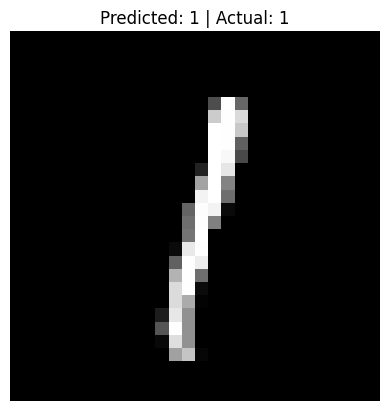

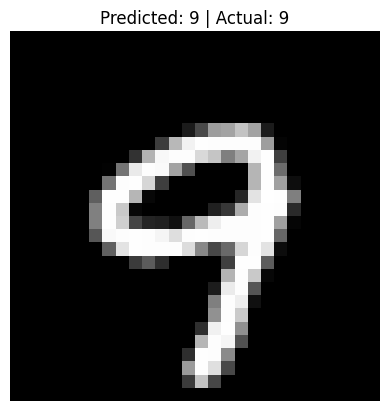

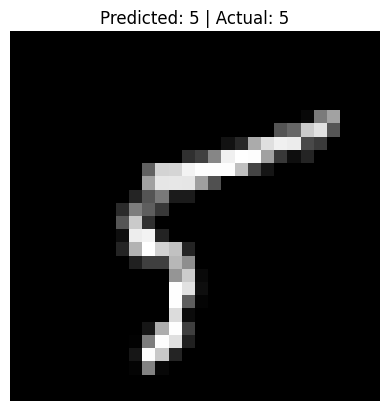

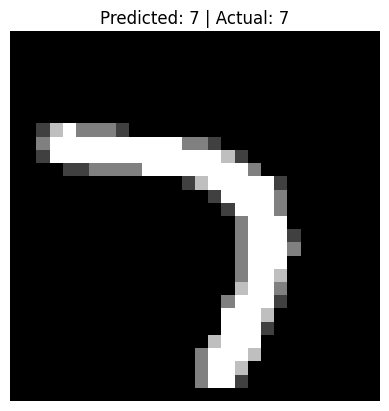

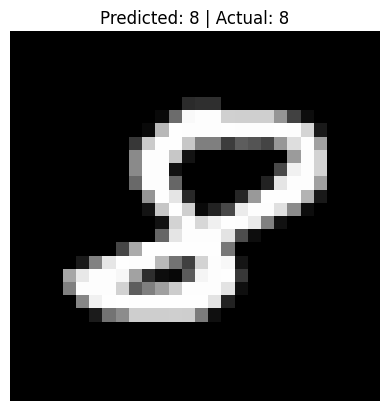

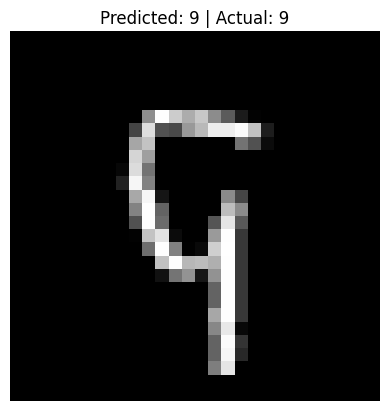

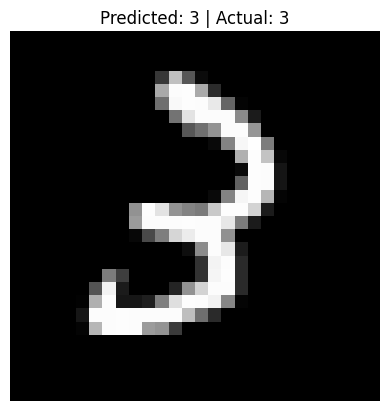

In [27]:
model.eval()
images, labels = next(iter(test_loader))

images = images.to(device)
labels = labels.to(device)

import matplotlib.pyplot as plt

for i in range(len(images)):  
    image = images[i].unsqueeze(0)
    true_label = labels[i].item()

    with torch.no_grad():
        output = model(image)
        predicted_label = torch.argmax(output, dim=1).item()

    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_label} | Actual: {true_label}")
    plt.axis('off')
    plt.show()

